In [5]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import shap
#import eli5
#from eli5.sklearn import PermutationImportance

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [7]:
data=pd.read_excel('./use.xlsx')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1106)
feature=train_data.drop(['Y','Unnamed: 0'],axis=1)
label=train_data['Y']

In [8]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [10]:
def ETR_cv(n_estimators, min_samples_split, max_depth):
    val = cross_val_score(
        ExtraTreesRegressor(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            random_state=1314
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [ ]:
ETR_opt = BayesianOptimization(
        ETR_cv,
        {'n_estimators': (50, 1000),
        'min_samples_split': (2, 25),
        'max_depth': (2, 15)}
    )

In [ ]:
ETR_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.3516    | 10.15     | 12.05     | 986.7     |
| 2         | 0.2991    | 7.396     | 7.627     | 991.0     |
| 3         | 0.4169    | 13.94     | 10.24     | 462.8     |
| 4         | 0.2591    | 8.399     | 18.82     | 444.2     |
| 5         | 0.3222    | 14.26     | 21.21     | 613.0     |
| 6         | 0.3707    | 10.52     | 9.799     | 428.7     |
| 7         | 0.36      | 10.87     | 11.91     | 681.5     |
| 8         | 0.1626    | 5.577     | 13.29     | 120.8     |
| 9         | 0.2955    | 12.82     | 23.3      | 260.3     |
| 10        | 0.3575    | 14.48     | 17.58     | 685.3     |
| 11        | 0.3213    | 10.1      | 15.93     | 528.4     |
| 12        | 0.191     | 6.271     | 18.53     | 954.0     |
| 13        | 0.4872    | 15.0      | 6.84      | 470.5     |
| 14        | 0.4065    | 15.0      | 13.79     | 478.3     |
| 15    

In [ ]:
ETR_opt.max

{'target': 0.5360188756232477,
 'params': {'max_depth': 15.0,
  'min_samples_split': 2.0,
  'n_estimators': 429.9672404158381}}

In [11]:
model = ExtraTreesRegressor(n_estimators=861,
                            # min_samples_split=2,
                            max_depth=28,
                            # max_samples=370,
                            # bootstrap=True,
                            n_jobs=-1,
                            random_state=1314).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.8077928836619762
rmse: 0.06640329288220229


In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Y','Unnamed: 0'],axis=1)
test_y = test_data['Y']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9941043173373609
MAE: 0.011610842096424634
测试集得分为： 0.7714986092887184 0.0686340571010429


In [13]:
# 预测
Y1=model.predict(X=test_data.drop(['Y','Unnamed: 0'],axis=1))
Y2=test_data['Y']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)
pred_show

,Y_pred,Y_True
355,0.120031,0.141050
51,0.091549,0.080100
243,0.127454,0.123750
426,0.288229,0.329000
161,0.289066,0.317688
...,...,...
57,0.144279,0.160650
110,0.285470,0.248400
146,0.213454,0.061600
291,0.181240,0.176000


In [14]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

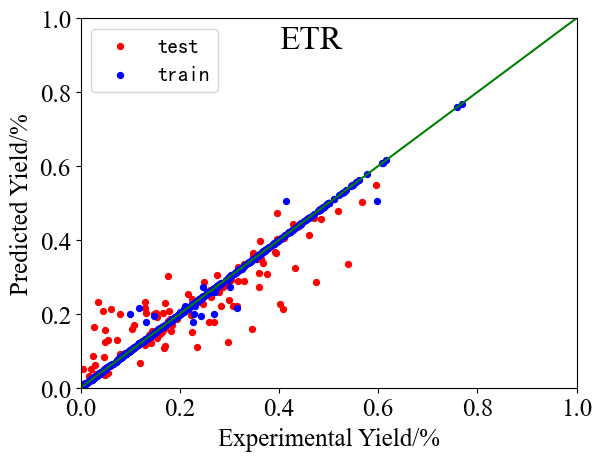

In [15]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=18,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=18,label='train')
plt.xlim((0,1))
plt.xlabel('Experimental Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=18,fontname='Times New Roman')
plt.ylim((0,1))
plt.ylabel('Predicted Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=18,fontname='Times New Roman')
plt.plot([0,1],[0,1],color='g')
plt.text(0.4,0.92,'ETR',fontsize=24,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=15)
plt.show()

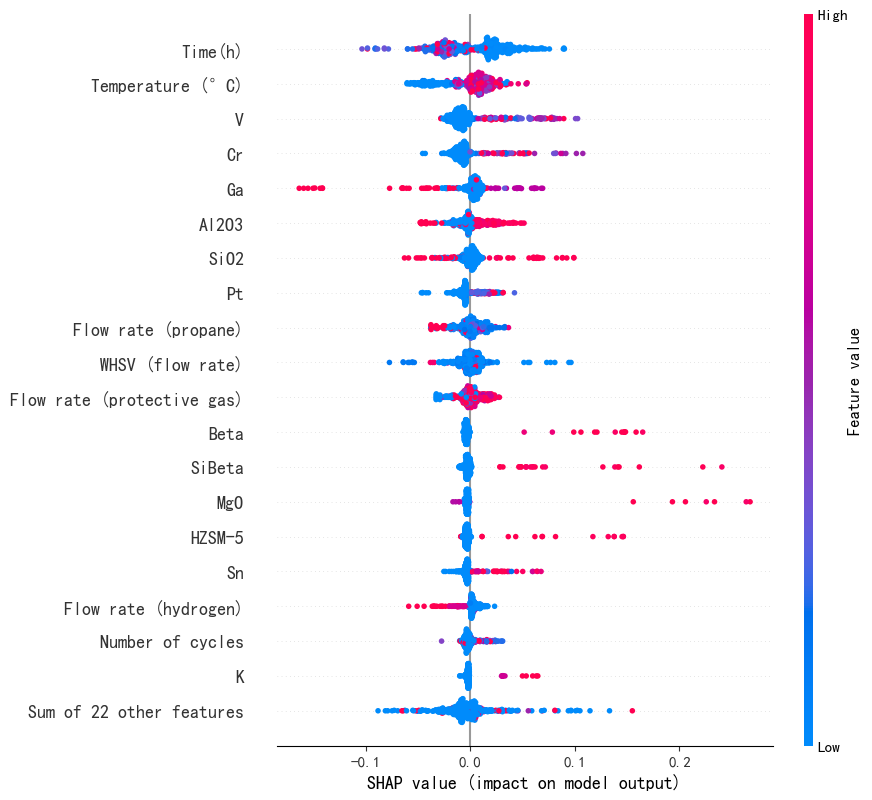

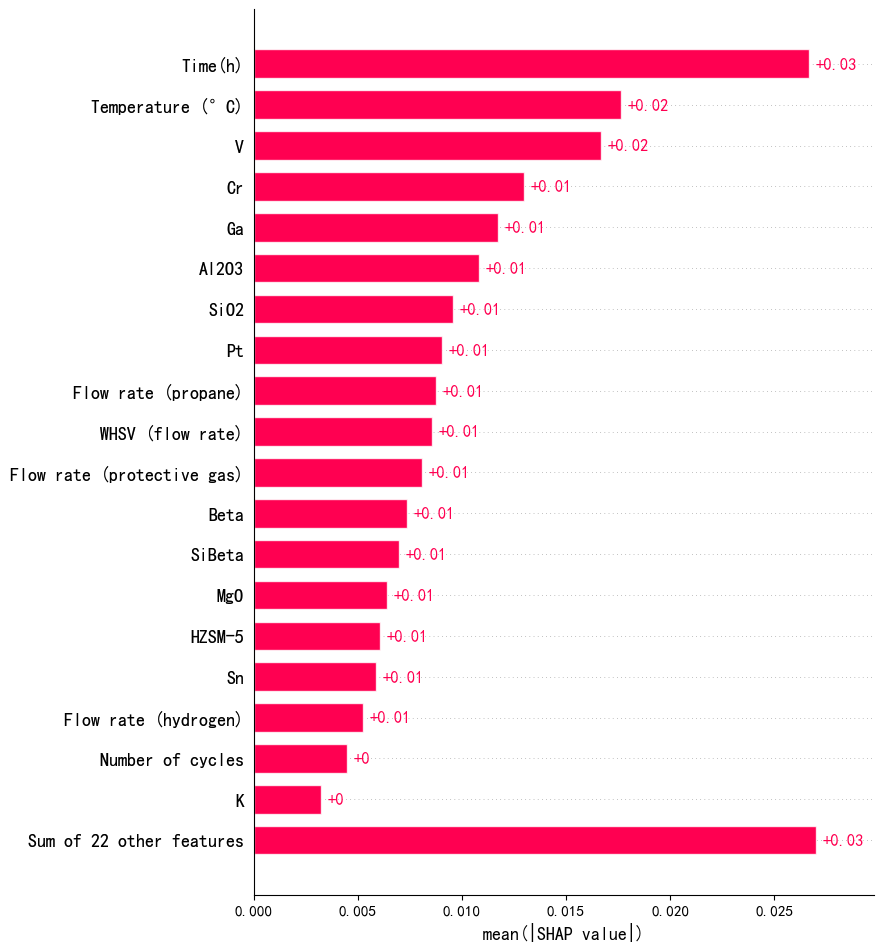

In [16]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)

In [ ]:
# 排序特征重要性
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.2135 ± 0.0951,时间(h)
0.1275 ± 0.0586,SiO2
0.1257 ± 0.0171,Beta
0.1212 ± 0.0378,Cr
0.1072 ± 0.0472,MgO
0.1043 ± 0.0628,温度(_摄氏度)
0.0963 ± 0.0196,V
0.0945 ± 0.0194,Pt
0.0757 ± 0.0523,WHSV(流量)
0.0688 ± 0.0720,SiBeta
